https://stats.stackexchange.com/questions/437365/pyro-gaussian-processes-regression-achieves-a-low-error-but-then-always-outputs

https://docs.gpytorch.ai/en/stable/index.html

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import arviz as az


plt.style.use("ggplot")
pyro.set_rng_seed(1209)
figsize = (7, 5)


# ToDo

* Replace g 
* Replace gen_data - DONE
* Replace neg_log_likelihood - DONE
* check Oswin notes for neg_log_likelihood
* Funktion til at plotte GP med test, trainign, mean og variance

* Change kernel to linear + periodic
* Check if loss calculation is the same as getting mu and cov from model.

In [16]:
def g(x):
    return -(torch.sin(6 * np.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


In [17]:
def neg_log_likelihood(x, y, GP):
    kernel = GP.kernel
    noise_y = GP.noise
    n_samples = len(x)
    K = kernel.forward(x)

    # ToDo mention that we are using the Cholesky decomposition
    # for the numerical stability of the computation
    # and for performance reasons
    # also add reference to the book

    # Compute the Cholesky decomposition
    upper = False
    L = torch.linalg.cholesky(K + noise_y * torch.eye(n_samples), upper=upper)

    alpha = torch.cholesky_solve(y.reshape(-1, 1), L, upper=upper)
    alpha = alpha.squeeze()
    # L being a diagonal matrix has the determinant equal to the sum of the log of
    # the element on the diagonal
    log_det = torch.sum(torch.log(torch.diag(L)))

    # Negative log-likelihood
    NLL = 0.5 * (
        torch.dot(y.T, alpha)
        + log_det
        + n_samples * torch.log(torch.tensor(2.0) * torch.pi)
    )

    return NLL

In [18]:
# def neg_log_likelihood(x, y, GP):
#     kernel = GP.kernel
#     noise_y = GP.noise
#     n = len(y)
#     K = kernel.forward(x)
#     like1 = 1 / 2 * y @ torch.linalg.inv(noise_y * torch.eye(n) + K) @ y
#     like2 = 1 / 2 * torch.log(torch.linalg.det(noise_y * torch.eye(n) + K))
#     like3 = n / 2 * torch.log(2 * torch.tensor(np.pi))
#     return like1 + like2 + like3


In [19]:
def neg_likelihood_prior_joint(x, y, GP, priors):
    params = [
        GP.noise,
        kernel.kern0.lengthscale,
        kernel.kern0.variance,
        kernel.kern1.variance,
        kernel.kern1.period,
        kernel.kern1.lengthscale,
    ]
    neg_likelihood = neg_log_likelihood(x, y, GP)
    log_prob_prior = torch.tensor(0.0)
    for dist, value in zip(priors, params):
        log_prob_prior += dist.log_prob(value)
    return neg_likelihood - log_prob_prior


## Plot of generating function $g$

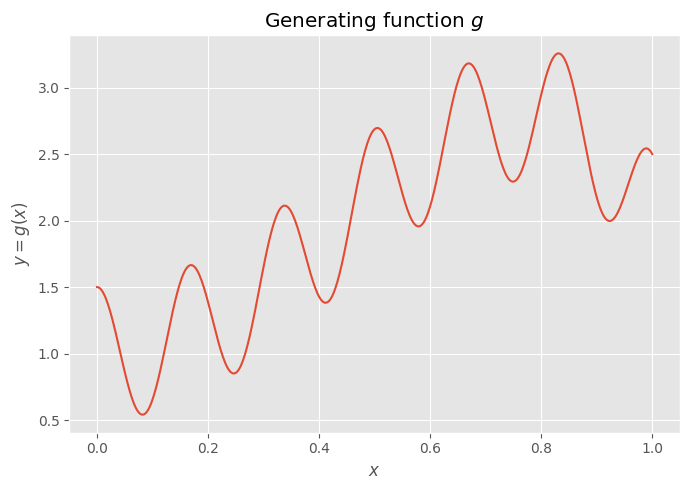

In [20]:
n_points = 500
xs = torch.linspace(0.0, 1.0, n_points)
ys = g(xs)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(xs, ys)
ax.set_title(r"Generating function $g$")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y=g(x)$")
plt.tight_layout()
plt.show()


# Training and test data

We assume observations are given by:

$$
y_i = g(x_i) + \epsilon_i, \quad 
$$

where the observations are the grid $x_i = \frac{i-1}{l-1}, i=1,\ldots,l$ with $l=30$.

In [21]:
def generate_data(l=30, split=1.0 / 3.0):
    """
    Generate training and test data for the function g(x) = -(sin(6*pi*x)^2) + 6x^2 - 5x^4 + 3/2.
    :param l: Number of data points.
    :param split: Fraction of data to use as test data.
    :return: x_train, y_train, x_test, y_test
    """
    x = (torch.arange(1, l + 1) - 1) / (l - 1)
    y = g(x) + torch.sqrt(torch.tensor(0.01)) * torch.randn(len(x))

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=split, random_state=3317
    )

    return x_train, y_train, x_test, y_test

In [22]:
x_train, y_train, x_test, y_test = generate_data()

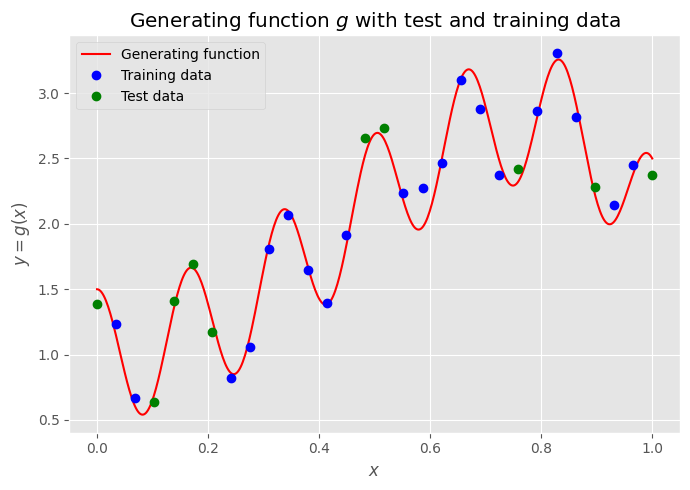

In [23]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(xs, ys, label="Generating function", color="red")
ax.plot(x_train, y_train, "o", label="Training data", color="blue")
ax.plot(x_test, y_test, "o", label="Test data", color="green")
ax.set_title(r"Generating function $g$ with test and training data")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y=g(x)$")
ax.legend()
plt.tight_layout()
plt.show()


## Setup Gaussian kernel

In [24]:
# Choice of kernel:
# Data is periodic, so we use a periodic kernel
# Data is increasing, so we use a linear kernel
# Sum of kernels is also a kernel
# We use a sum of a linear and a periodic kernel
# The periodic kernel is due to David Mackey: Introduction to Gaussian Processes, eq. 47
# Kernel cookbook: https://www.cs.toronto.edu/~duvenaud/cookbook/

# the linear kernel alone is equivalent to a linear regression

# refer to the "the kernel cookbook" for more information on kernels

# play around with the hyperparameters to see how they affect the model

linear = gp.kernels.Linear(input_dim=1, variance=torch.tensor(2.0))


rbf = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
)

periodic = gp.kernels.Periodic(
    input_dim=1,
    period=torch.tensor(1 / 3),
    lengthscale=torch.tensor(2.0),
    variance=torch.tensor(1.0),
)

kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)


## Perform GP regression with chosen kernel

Note this is done for a fixed set of kernel parameters.

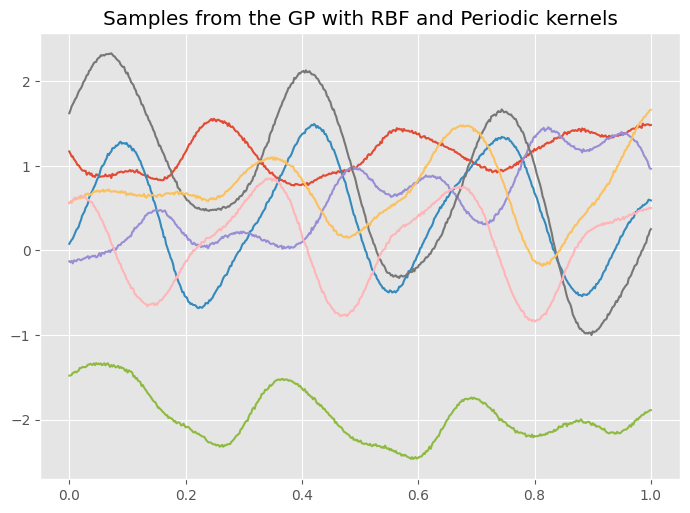

In [25]:
gpr = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(0.01))

# Samples from the GP
n_samples = 7

cov = kernel.forward(xs)
samples = dist.MultivariateNormal(
    torch.zeros(n_points),
    covariance_matrix=cov
    + torch.diag(torch.ones(n_points) * 0.0001),  ## ToDo should noise be added here?
).sample(sample_shape=(n_samples,))

fig, ax = plt.subplots(figsize=figsize)

for sample in samples:
    ax.plot(xs, sample)

plt.tight_layout()
plt.title("Samples from the GP with RBF and Periodic kernels")
plt.show()


## Plot GP regression (no tuning of hyperparameters)

This is just a sanity check to see if model is capable of matching data

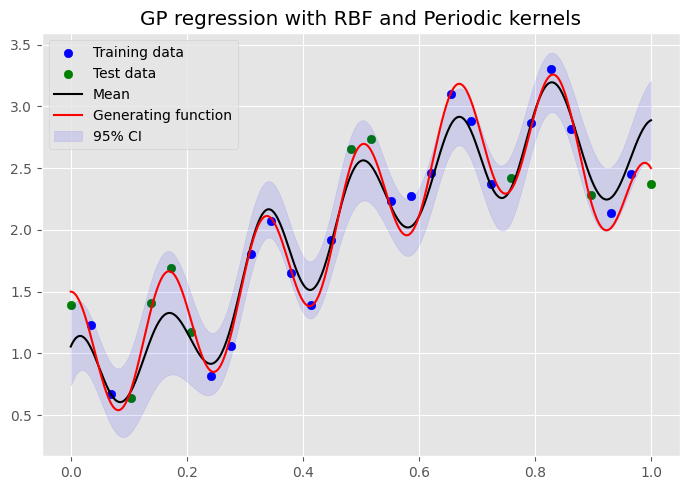

In [26]:
with torch.no_grad():
    mean, cov = gpr(xs, noiseless=False)

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(x_train, y_train, label="Training data", color="blue")
ax.scatter(x_test, y_test, label="Test data", color="green")
ax.plot(xs, mean, label="Mean", color="black")
ax.plot(xs, ys, label="Generating function", color="red")
ax.fill_between(
    xs,
    mean + torch.sqrt(cov) * 1.95996,
    mean - torch.sqrt(cov) * 1.95996,
    color="blue",
    alpha=0.1,
    label="95% CI",
)
ax.set_title("GP regression with RBF and Periodic kernels")
ax.legend()
plt.tight_layout()
plt.show()

## Use gradient descent to find optimal hyperparameters $\theta$

In [27]:
losses_list = []
neg_likelihood_prior_joints_list = []
test_loglikelihoods = []
GPRs = []

generated_data_list = []

smoke_test = False
iterations = 20 if not smoke_test else 2

for i in range(iterations):
    print(f"Iteration {i + 1}/{iterations}")
    pyro.clear_param_store()
    x_train, y_train, x_test, y_test = generate_data()
    generated_data_list.append((x_train, y_train, x_test, y_test))

    # Defining our kernels and GP-model
    linear = gp.kernels.Linear(input_dim=1, variance=torch.tensor(2.0))

    rbf = gp.kernels.RBF(
        input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
    )
    periodic = gp.kernels.Periodic(
        input_dim=1,
        period=torch.tensor(0.5),
        lengthscale=torch.tensor(1.0),
        variance=torch.tensor(1.0),
    )
    kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)
    # kernel = periodic
    gpr = gp.models.GPRegression(
        x_train, y_train, kernel=kernel, noise=torch.tensor(0.01)
    )

    # Putting priors on our kernel parameters
    gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))

    gpr.kernel.kern1.period = pyro.nn.PyroSample(dist.Exponential(4.0))
    gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
    # gpr.kernel.period = pyro.nn.PyroSample(dist.Exponential(1 / 3))
    # gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    # gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
    gpr.noise = pyro.nn.PyroSample(dist.Gamma(1.0, 1.0))  # Hvad er dette noise til?
    priors = [  # disse kan defineres udenfor loop
        dist.Gamma(1, 1),
        dist.LogNormal(0, 1),
        dist.LogNormal(1, 1),
        dist.LogNormal(1, 1),
        dist.Exponential(4.0),
        dist.LogNormal(0, 1),
    ]

    # SVI with delta distribution as guide
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.001)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss  # ToDO er der andre loss fns
    losses = []
    neg_likelihood_prior_joints = []
    num_steps = 3000
    for i in tqdm(range(num_steps)):  # Brug tqdm
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        gpr.set_mode("guide")
        neg_likelihood_prior_joints.append(
            neg_likelihood_prior_joint(x_train, y_train, gpr, priors).detach().numpy()
        )
        gpr.set_mode("model")

    gpr.set_mode("guide")

    # original code
    losses_list.append(losses)
    neg_likelihood_prior_joints_list.append(neg_likelihood_prior_joints)
    test_loglikelihoods.append(-neg_log_likelihood(x_test, y_test, gpr))

    GPRs.append(gpr)


Iteration 1/20


100%|██████████| 3000/3000 [00:06<00:00, 436.79it/s]


Iteration 2/20


100%|██████████| 3000/3000 [00:06<00:00, 438.83it/s]


Iteration 3/20


100%|██████████| 3000/3000 [00:07<00:00, 395.69it/s]


Iteration 4/20


100%|██████████| 3000/3000 [00:07<00:00, 387.45it/s]


Iteration 5/20


100%|██████████| 3000/3000 [00:07<00:00, 406.07it/s]


Iteration 6/20


100%|██████████| 3000/3000 [00:07<00:00, 407.37it/s]


Iteration 7/20


100%|██████████| 3000/3000 [00:07<00:00, 409.11it/s]


Iteration 8/20


100%|██████████| 3000/3000 [00:07<00:00, 410.18it/s]


Iteration 9/20


100%|██████████| 3000/3000 [00:07<00:00, 411.72it/s]


Iteration 10/20


100%|██████████| 3000/3000 [00:07<00:00, 408.86it/s]


Iteration 11/20


100%|██████████| 3000/3000 [00:06<00:00, 433.23it/s]


Iteration 12/20


100%|██████████| 3000/3000 [00:06<00:00, 462.58it/s]


Iteration 13/20


100%|██████████| 3000/3000 [00:06<00:00, 465.72it/s]


Iteration 14/20


100%|██████████| 3000/3000 [00:06<00:00, 457.58it/s]


Iteration 15/20


100%|██████████| 3000/3000 [00:06<00:00, 460.11it/s]


Iteration 16/20


100%|██████████| 3000/3000 [00:06<00:00, 462.55it/s]


Iteration 17/20


100%|██████████| 3000/3000 [00:06<00:00, 459.51it/s]


Iteration 18/20


100%|██████████| 3000/3000 [00:06<00:00, 461.84it/s]


Iteration 19/20


100%|██████████| 3000/3000 [00:06<00:00, 461.79it/s]


Iteration 20/20


100%|██████████| 3000/3000 [00:06<00:00, 457.85it/s]


In [28]:
# test_loglikelihoods  # .detach().cpu().numpy()
map_log_likelihood = [x.detach().item() for x in test_loglikelihoods]


[-9.865070343017578,
 -10.751142501831055,
 -10.868415832519531,
 -13.235424041748047,
 -10.996277809143066,
 -10.228208541870117,
 -13.128461837768555,
 -12.265609741210938,
 -9.890976905822754,
 -11.939689636230469,
 -15.453397750854492,
 -11.774103164672852,
 -12.111454963684082,
 -10.86875057220459,
 -10.936691284179688,
 -12.396835327148438,
 -11.09447956085205,
 -11.50871753692627,
 -10.81363296508789,
 -11.474879264831543]

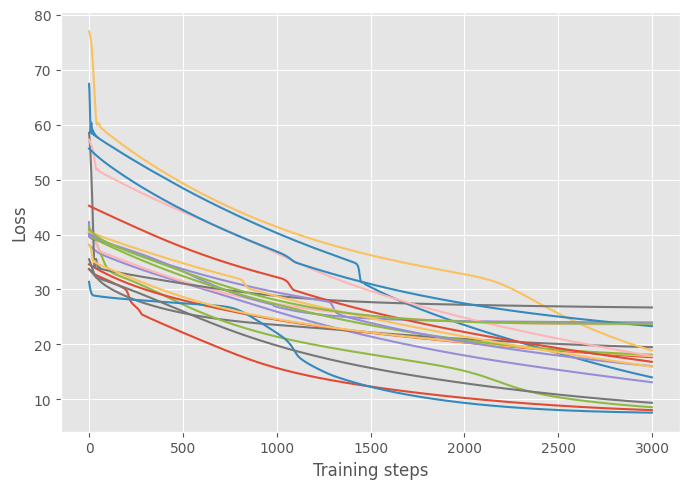

In [29]:
fig, ax = plt.subplots(figsize=figsize)

ax.set_xlabel("Training steps")
ax.set_ylabel("Loss")
for l in losses_list:
    ax.plot(l)

plt.tight_layout()
plt.show()


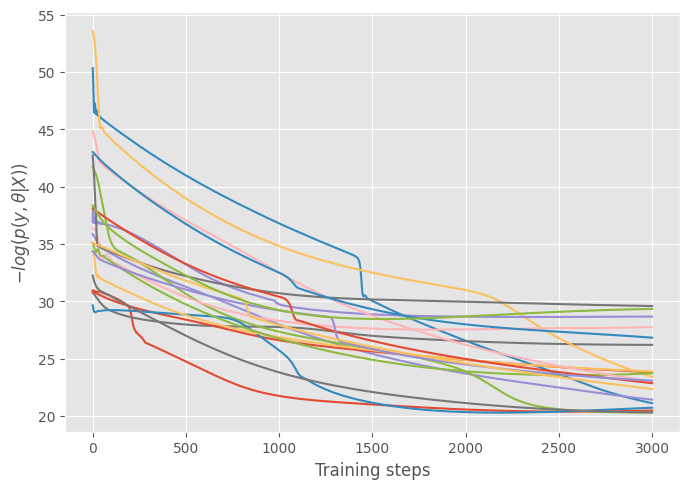

In [30]:
fig, ax = plt.subplots(figsize=figsize)

ax.set_xlabel("Training steps")
ax.set_ylabel(r"$-log(p(y, \theta | X))$")
for l in neg_likelihood_prior_joints_list:
    ax.plot(l)

plt.tight_layout()
plt.show()


In [31]:
torch.mean(torch.tensor(test_loglikelihoods))

tensor(-11.5801)

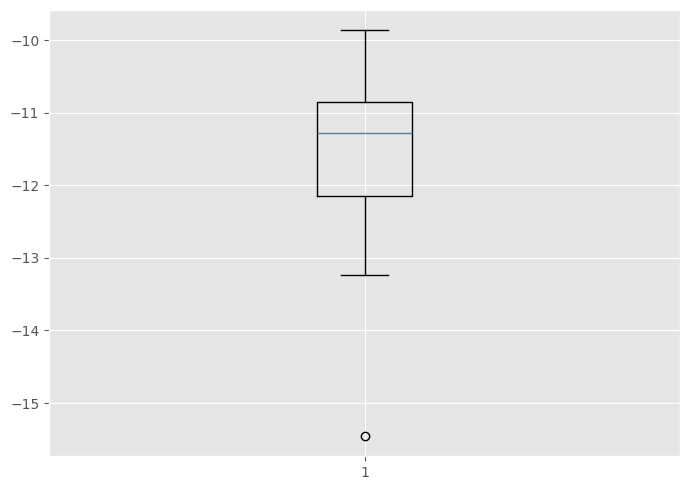

In [32]:
[x.detach().item() for x in test_loglikelihoods]

fig, ax = plt.subplots(figsize=figsize)

ax.boxplot([x.detach().item() for x in test_loglikelihoods])
plt.tight_layout()
plt.show()


# Måske histogrammer af MAPs

In [34]:
def plotfct(generated_data_list, xs, ys, mean, cov, i):
    fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(  # ToDo -  Træk ud som funktion
        generated_data_list[i][0],
        generated_data_list[i][1],
        color="blue",
        label="Train data",
    )  # plot train data
    ax.scatter(
        generated_data_list[i][2],
        generated_data_list[i][3],
        color="red",
        label="Test data",
    )  # plot test data
    ax.plot(xs, mean, color="blue", label="Prediction mean")  # plot mean
    ax.plot(xs, ys, color="orange", label=r"$g(x)$")  # plot g(x)
    ax.fill_between(
        xs,
        mean + torch.sqrt(cov) * 1.95,
        mean - torch.sqrt(cov) * 1.95,
        color="blue",
        alpha=0.1,
        label="Prediction variance",
    )  # plot var
    ax.set_title(
        f"GP regression with sum of RBF and Periodic kernels - iteration {i+1}"
    )
    ax.legend()

    plt.tight_layout()
    plt.show()

In [245]:
mean.shape, cov.shape

(torch.Size([500]), torch.Size([500]))

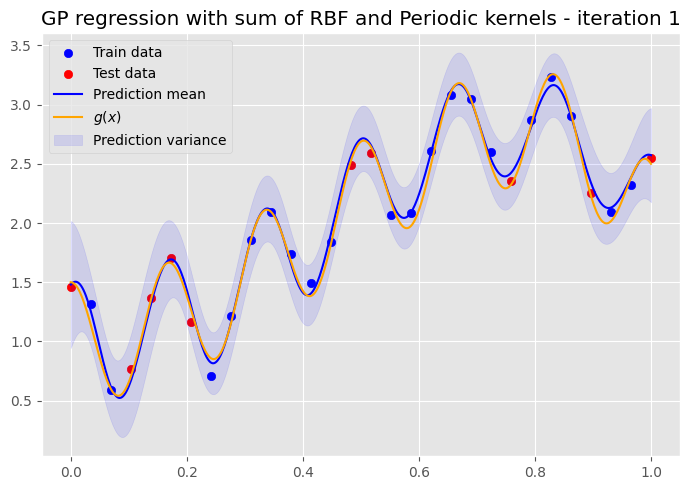

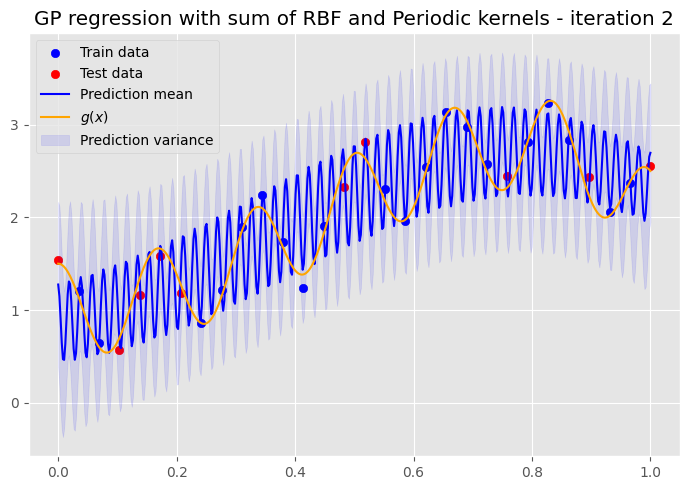

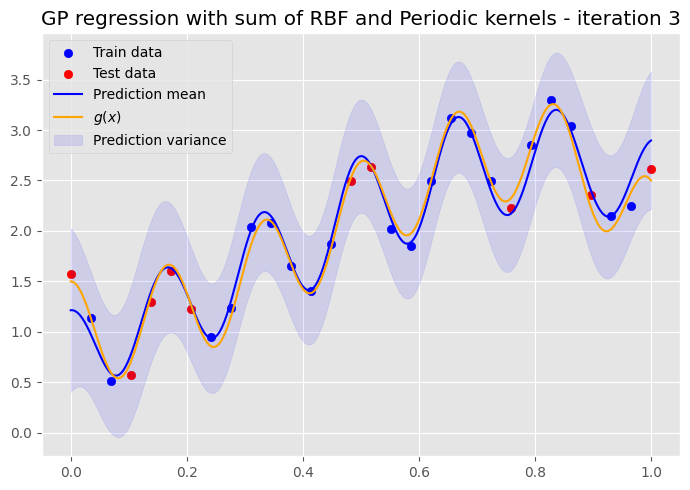

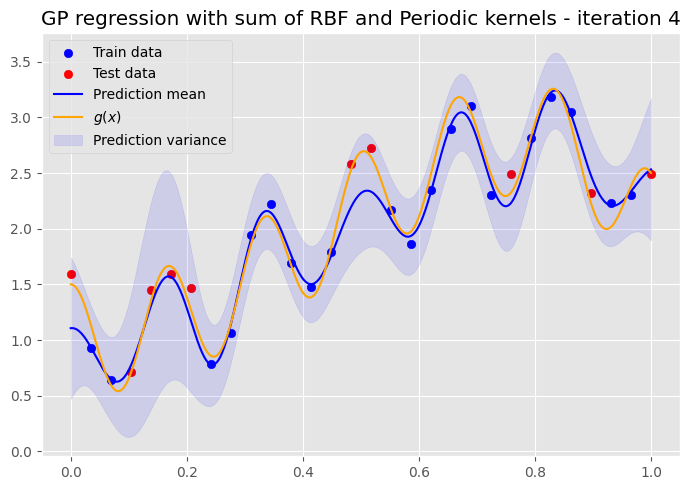

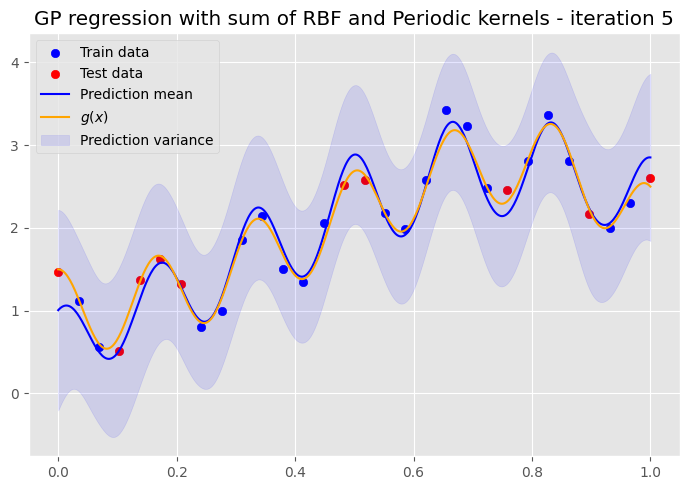

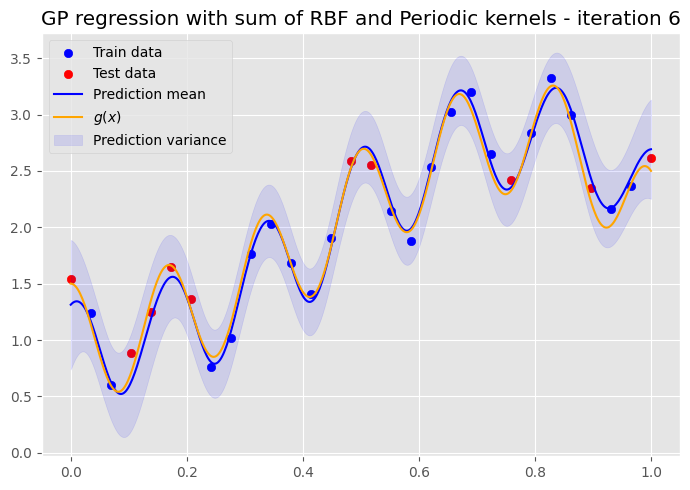

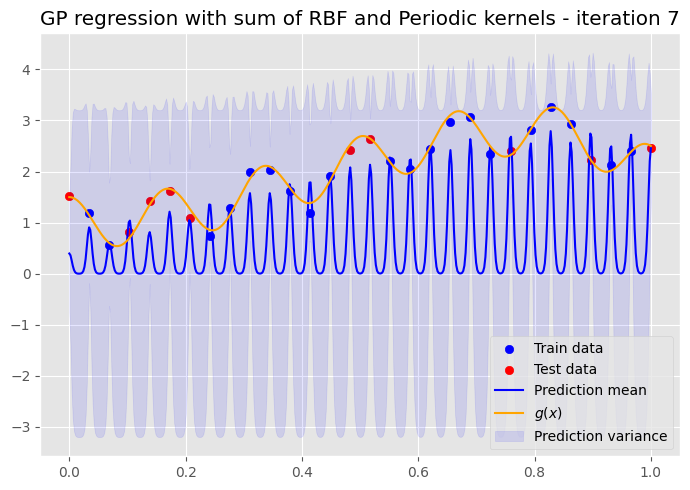

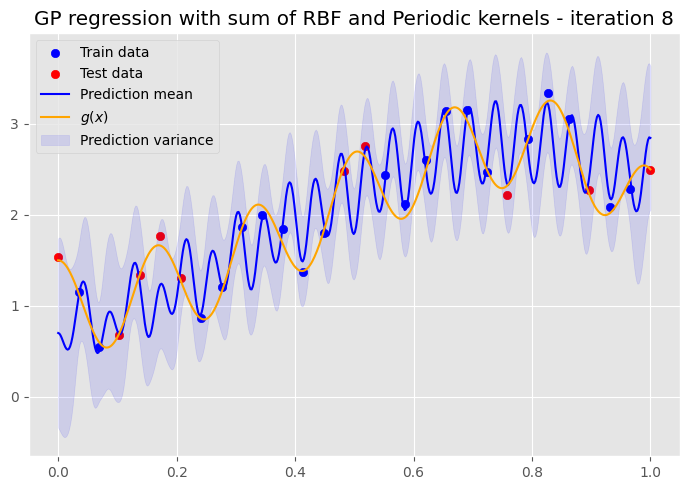

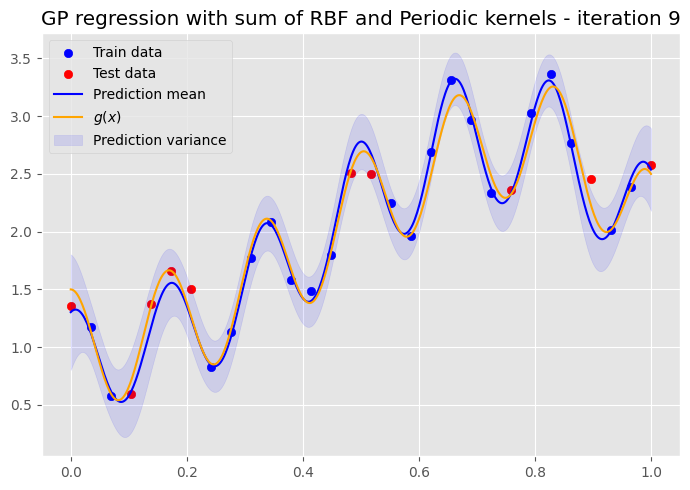

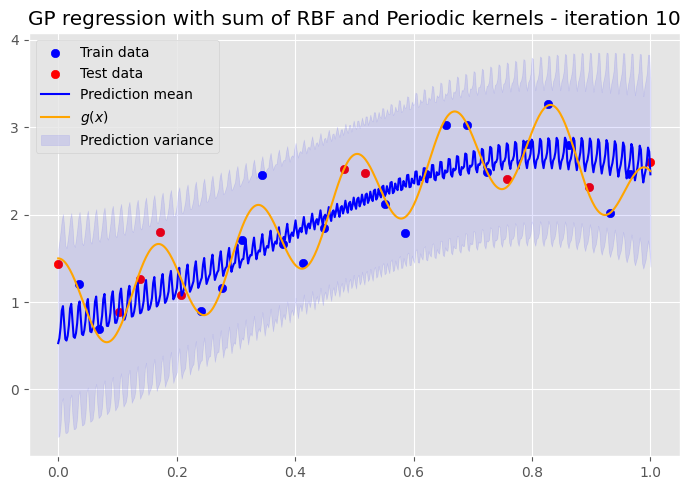

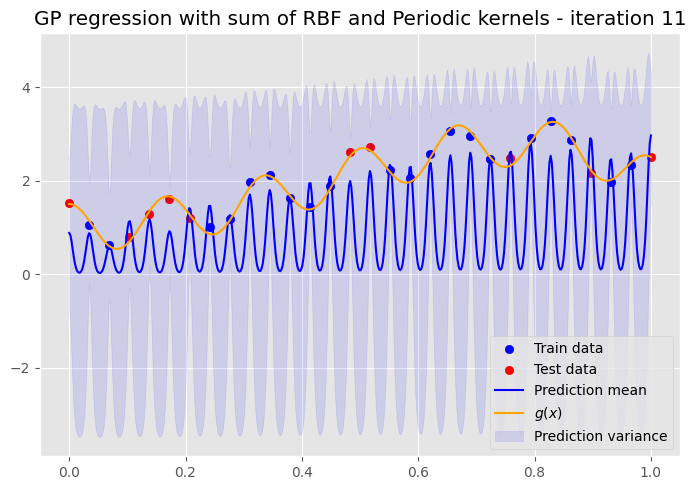

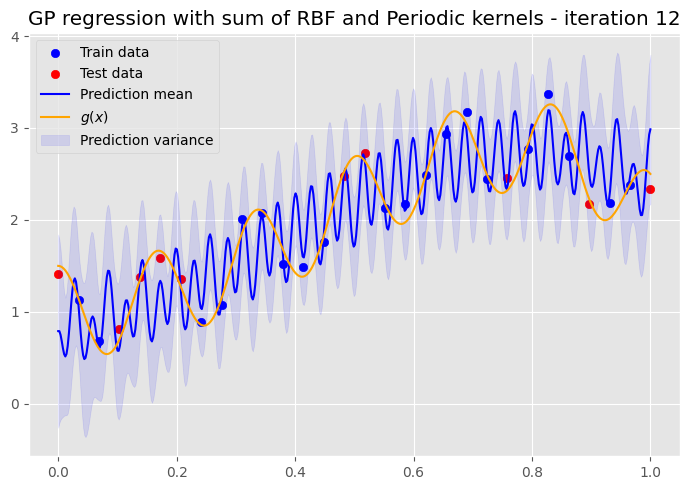

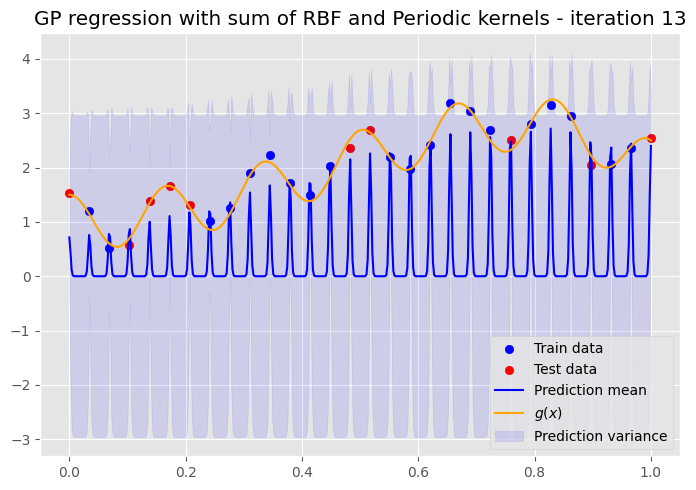

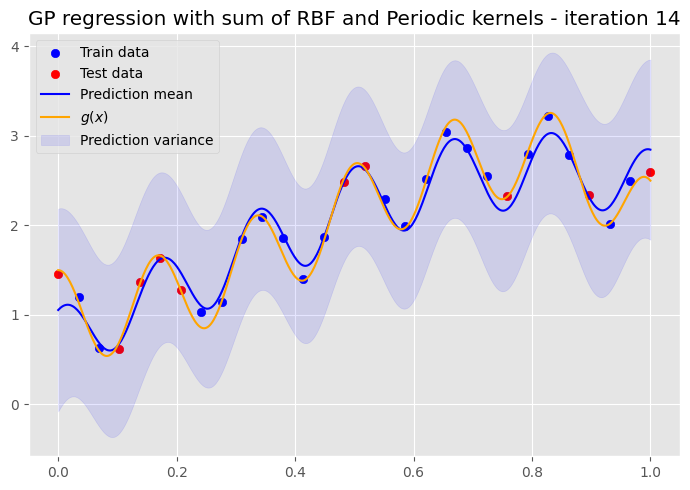

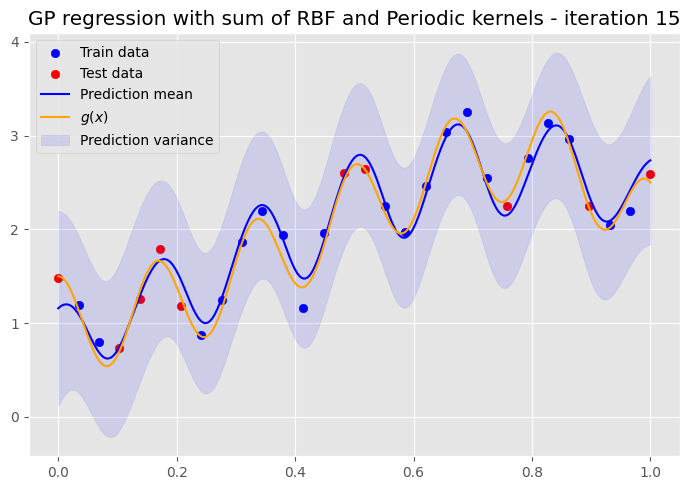

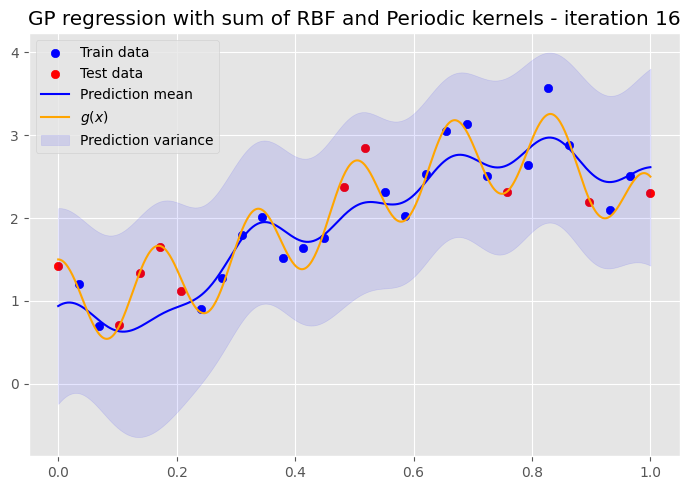

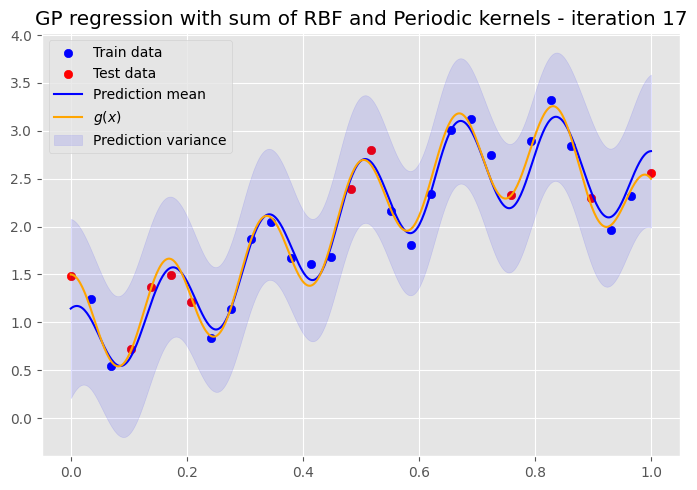

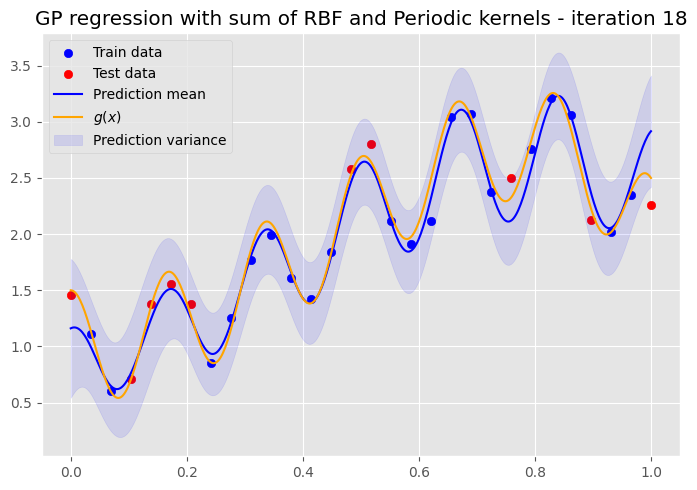

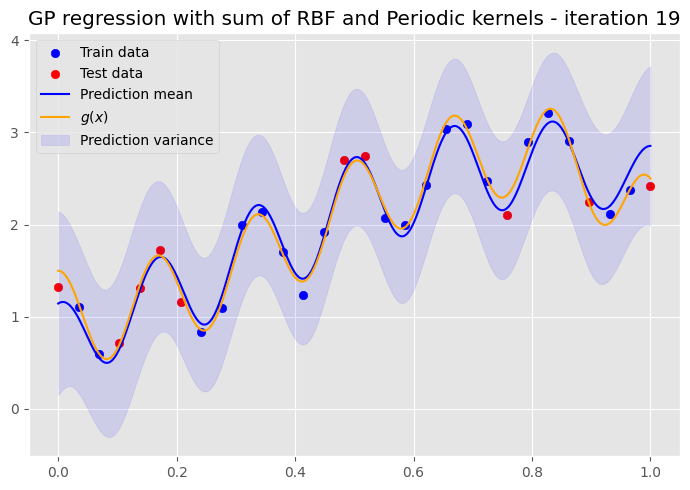

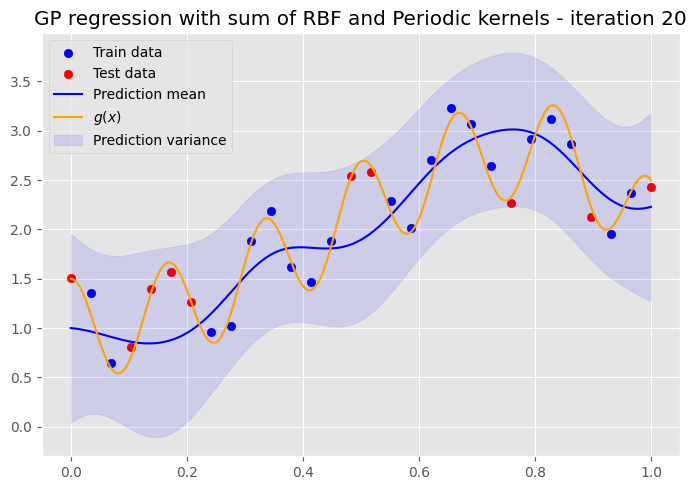

In [35]:
for i, gauss_p in enumerate(GPRs):
    pyro.clear_param_store()
    gauss_p.set_mode("guide")
    with torch.no_grad():
        mean, cov = gauss_p(xs, noiseless=False)
    # print(f"mean: {mean} - cov: {cov}")
    plotfct(generated_data_list, xs, ys, mean, cov, i)
    # if i == 6:
    #     plt.savefig("GP_MAP_fit.png")


# Example of train data
# plt.scatter(generated_data_list[0][0], generated_data_list[0][1])


In [247]:
GPRs[0].set_mode("guide")
print(GPRs[0].kernel.kern0.lengthscale)
print(GPRs[0].kernel.kern0.variance)
print(GPRs[0].kernel.kern1.period)
print(GPRs[0].kernel.kern1.lengthscale)
print(GPRs[0].kernel.kern1.variance)


tensor(0.5227, grad_fn=<ExpandBackward0>)
tensor(1.3730, grad_fn=<ExpandBackward0>)
tensor(0.1683, grad_fn=<ExpandBackward0>)
tensor(3.6424, grad_fn=<ExpandBackward0>)
tensor(1.3300, grad_fn=<ExpandBackward0>)


In [ ]:
def log_likelihood_nuts(x, y, params):
    rbf = gp.kernels.RBF(input_dim=1, variance=params[1], lengthscale=params[0])
    periodic = gp.kernels.Periodic(
        input_dim=1, period=params[3], lengthscale=params[2], variance=params[4]
    )
    kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)
    noise_y = params[5]
    n = len(y)
    K = kernel.forward(x)
    like1 = -1 / 2 * y @ torch.linalg.inv(noise_y * torch.eye(n) + K) @ y
    like2 = -1 / 2 * torch.log(torch.linalg.det(noise_y * torch.eye(n) + K))
    like3 = -n / 2 * torch.log(2 * torch.tensor(np.pi))
    return like1 + like2 + like3


def approximate_log_likelihood(x, y, posterior_samples):
    log_likelihoods = []
    for rbf_l, rbf_v, per_l, per_p, per_v, noise in zip(
        posterior_samples["kernel.kern0.lengthscale"],
        posterior_samples["kernel.kern0.variance"],
        posterior_samples["kernel.kern1.lengthscale"],
        posterior_samples["kernel.kern1.period"],
        posterior_samples["kernel.kern1.variance"],
        posterior_samples["noise"],
    ):
        # print(rbf_l, rbf_v, per_l, per_p, per_v, noise)
        log_likelihoods.append(
            log_likelihood_nuts(x, y, [rbf_l, rbf_v, per_l, per_p, per_v, noise])
        )
    return torch.tensor(log_likelihood_nuts).mean()


In [ ]:
x_train, y_train, x_test, y_test = generate_data()

# Defining our kernels and GP-model
rbf = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
)
periodic = gp.kernels.Periodic(
    input_dim=1,
    period=torch.tensor(0.5),
    lengthscale=torch.tensor(1.0),
    variance=torch.tensor(1.0),
)
kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)
gpr = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(0.01))

# Putting priors on our kernel parameters
gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
gpr.kernel.kern1.period = pyro.nn.PyroSample(dist.Exponential(4.0))
gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
gpr.noise = pyro.nn.PyroSample(dist.Gamma(1.0, 1.0))


nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=1000)
mcmc.run()


In [ ]:
arviz_data = az.from_pyro(mcmc)
az.plot_trace(arviz_data)
plt.tight_layout()
plt.savefig("arviz_trace.png", dpi=400)
az.plot_posterior(arviz_data)
plt.tight_layout()
plt.savefig("arviz_posterior.png", dpi=400)
summ = az.summary(arviz_data)


In [ ]:
# import pandas as pd

# summ = az.summary(arviz_data)
# df = pd.DataFrame(summ)
# print(df.to_latex())


In [ ]:
test_loglikelihoods = []
generated_data_list = []

for i in range(20):
    print("Beginning iteration", i)
    pyro.clear_param_store()
    x_train, y_train, x_test, y_test = generate_data()
    generated_data_list.append((x_train, y_train, x_test, y_test))

    # Defining our kernels and GP-model
    rbf = gp.kernels.RBF(
        input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
    )
    periodic = gp.kernels.Periodic(
        input_dim=1,
        period=torch.tensor(0.5),
        lengthscale=torch.tensor(1.0),
        variance=torch.tensor(1.0),
    )
    kernel = gp.kernels.Sum(kern0=rbf, kern1=periodic)
    gpr = gp.models.GPRegression(
        x_train, y_train, kernel=kernel, noise=torch.tensor(0.01)
    )

    # Putting priors on our kernel parameters
    gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
    gpr.kernel.kern1.period = pyro.nn.PyroSample(dist.Exponential(4.0))
    gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
    gpr.noise = pyro.nn.PyroSample(dist.Gamma(1.0, 1.0))

    # SVI with delta distribution as guide

    nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=500)
    mcmc.run()
    samples_post = mcmc.get_samples()

    test_loglikelihoods.append(approximate_log_likelihood(x_test, y_test, samples_post))


In [ ]:
print(test_loglikelihoods)


In [ ]:
# mcmc_log_likelihood = [tensor.to_numpy() for tensor in test_loglikelihoods]
fig, ax = plt.subplots(figsize=(3, 3))
ax.errorbar(
    1,
    np.mean(map_log_likelihood),
    yerr=np.std(map_log_likelihood, ddof=1),
    ecolor="k",
    capsize=3,
    elinewidth=1,
    color="b",
    fmt="o",
)
ax.errorbar(
    2,
    np.mean(test_loglikelihoods),
    yerr=np.std(test_loglikelihoods, ddof=1),
    ecolor="k",
    capsize=3,
    elinewidth=1,
    color="r",
    fmt="o",
)
ax.set_xticks([1, 2], ["MAP", "NUTS"])
ax.set_xlim(0, 3)
ax.set(ylabel="Posterior log likelihood")
plt.tight_layout()
plt.savefig("B1_loglikelihood_comp.png", dpi=400)
plt.show()
print("MAP:", np.mean(map_log_likelihood), np.std(map_log_likelihood, ddof=1))
print("NUTS:", np.mean(test_loglikelihoods), np.std(test_loglikelihoods, ddof=1))
